In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score
import glob

def eval(labels, preds):
    """
    Evaluate clustering results using precision, recall, f1 score, and accuracy.
    """
    acc = np.mean(preds == labels)
    recall = recall_score(labels, preds, zero_division=0)
    precision = precision_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    return {"acc": acc, "recall": recall, "precision": precision, "f1": f1}

def load(fn):
    """
    Load dataset from the provided file path.
    """
    data = np.load(fn)
    df = pd.DataFrame({
        "pt_names": data['pt_names'],
        "channel_names": data['channel_names'],
        "starts": data['starts'],
        "ends": data['ends'],
        "detector": data['detector'],
        "spike": data['labels'][:, -1],
        "real": data['labels'][:, -2],
        "remove": data['labels'][:, -3],
        "reconstruct": data['reconstruct']
    })
    mu = data["mu"]
    return df, mu

def process_with_dbscan(fn, save_suffix="save", eps=0.5, min_samples=5):
    """
    Process the dataset with DBSCAN clustering and evaluate performance.
    """
   

# Define parameters for DBSCAN
suffix = "2023-12-28_3"
save_suffix = "save"
epoch = 81
eps = 1
min_samples = 1000

# Locate files
fns = glob.glob(f"res/{suffix}/fold_*/train_{epoch}.npz")
print("Found files:", fns)


Found files: ['res/2023-12-28_3/fold_4/train_81.npz', 'res/2023-12-28_3/fold_2/train_81.npz', 'res/2023-12-28_3/fold_0/train_81.npz', 'res/2023-12-28_3/fold_1/train_81.npz', 'res/2023-12-28_3/fold_3/train_81.npz']


In [2]:
fn = fns[0]

In [3]:
def sample_uniform_(df,mu, num_samples =2000):
    """
    Sample uniformly from the dataset.
    """
    np.random.seed(42)
    num_samples = min(num_samples, len(df))
    # print("df.shape: {}, mu.shape: {}, num_samples: {}".format(df.shape, mu.shape, num_samples))
    indexs = []
    expected_shape = 0
    for pt in df["pt_names"].unique():
        indexs.append(np.random.choice(df[df["pt_names"] == pt].index, min(num_samples, len(df[df["pt_names"] == pt].index)), replace=False))
        # print("indexs[-1].shape", indexs[-1].shape,"len:", df[df['pt_names'] == pt].shape)
        expected_shape += indexs[-1].shape[0]
    indexs = np.concatenate(indexs, 0)
    # print(indexs.shape,"expected_shape: {}".format(expected_shape))
    df_sampled, mu_sampled = df.iloc[indexs].copy(), mu[indexs].copy()
    # print("df_sampled shape: {} mu_sampled shape: {}".format(df_sampled.shape, mu_sampled.shape))
    return df.iloc[indexs], mu[indexs]
    

In [24]:
 # Load the training and testing datasets
df_train, mu_train = load(fn)
df_test, mu_test = load(fn.replace("train", "test"))
df_train, mu_train = sample_uniform_(df_train, mu_train, num_samples=10000)

# Combine features from mu and reconstruct for both train and test datasets
train_feature = np.concatenate([mu_train, df_train["reconstruct"].values.reshape(-1, 1)], axis=1)
test_feature = np.concatenate([mu_test, df_test["reconstruct"].values.reshape(-1, 1)], axis=1)

print("Train Feature Shape:", train_feature.shape, "Test Feature Shape:", test_feature.shape)



Train Feature Shape: (327048, 9) Test Feature Shape: (123840, 9)


In [25]:
# # Perform DBSCAN clustering
# clustering = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
# train_preds = clustering.fit_predict(train_feature)
# test_preds = clustering.fit_predict(test_feature)

# # Evaluate the clustering results
# train_eval = eval(df_train["spike"] > 0.5, train_preds)
# test_eval = eval(df_test["spike"] > 0.5, test_preds)

# print("Train Eval:", train_eval)
# print("Test Eval:", test_eval)
# return train_eval, test_eval

In [26]:
# GMM with K = 3 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
train_preds = gmm.fit_predict(train_feature)
test_preds = gmm.fit_predict(test_feature)

In [27]:
# real > 0.5 and spike > 0.5 label = 2
# real > 0.5 and spike < 0.5 label = 1
# real < 0.5 and spike > 0.5 label = 0
label = np.zeros(df_train.shape[0])
label[(df_train['real'] > 0.5) & (df_train['spike'] > 0.5)] = 2
label[(df_train['real'] > 0.5) & (df_train['spike'] < 0.5)] = 1
label[(df_train['real'] < 0.5)] = 0

In [28]:
# calculate the homogeneity score
from sklearn.metrics import homogeneity_score
homogeneity_score(label, train_preds)

0.42634061364567777

In [29]:
# plt.hist(label)

(array([52255.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 32201.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 39879.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 

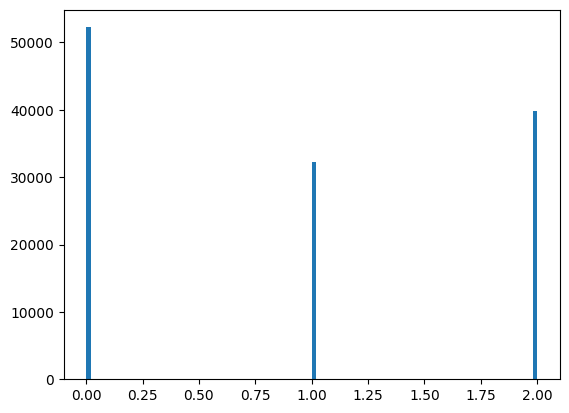

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(train_preds, bins=100)

In [14]:
# # Tsne visualization
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# tsne =  TSNE(n_components=2, n_jobs=-1)
# train_tsne = tsne.fit_transform(train_feature)

In [15]:
# sample_index = np.random.choice(train_feature.shape[0], 2000, replace=False)
# train_tsne_sample = train_tsne[sample_index]
# train_preds_sample = train_preds[sample_index]

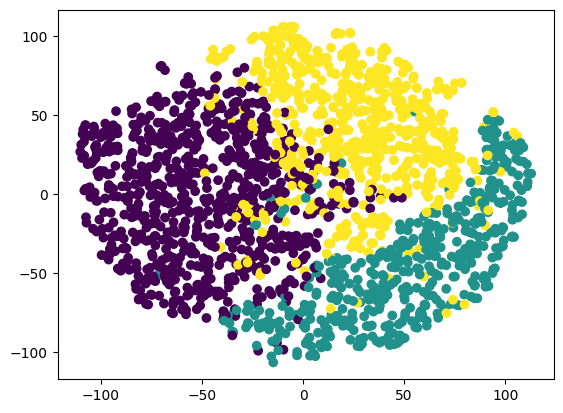

In [ ]:
#plt.scatter(train_tsne_sample[:, 0], train_tsne_sample[:, 1], c=train_preds_sample)

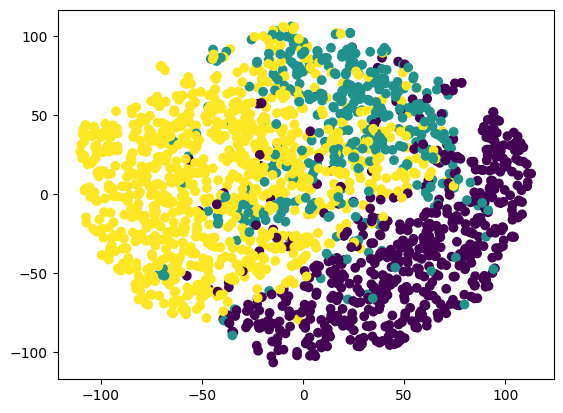

In [17]:
#plt.scatter(train_tsne_sample[:, 0], train_tsne_sample[:, 1], c=label[sample_index])

In [1]:
import numpy as np

In [2]:
loaded = np.load("/mnt/SSD5/yipeng/VAE/res/2023-12-28_3/fold_0/results/train_overall_.npz")

In [3]:
loaded.files    

['pt_names',
 'channel_names',
 'starts',
 'ends',
 'labels',
 'detector',
 'mu',
 'reconstruct',
 'pred',
 'pred_with_artifact',
 'pred_prob']

In [4]:
for key in loaded.keys():
    print(key, loaded[key].shape)

pt_names (153255,)
channel_names (153255,)
starts (153255,)
ends (153255,)
labels (153255, 5)
detector (153255,)
mu (153255, 8)
reconstruct (153255,)
pred (153255,)
pred_with_artifact (153255,)
pred_prob (153255,)
